In [264]:
import pandas as pd
import anndata as ad
from loguru import logger 
import time

import numpy as np
import tifffile

import matplotlib.pyplot as plt
import seaborn as sns

import shapely
import geopandas as gpd

import os
import sys
sys.path.append(os.path.abspath('../scripts'))
import utils
import importlib

import scimap as sm

Approach:   
1. Have a list of all sample ids
2. Process samples in anndata one image at a time for clarity and function refactor
3. join into single anndata

# Sample 990

In [265]:
path_to_quant = "../data/quantification/990_m150_s2_backsub_quantification.csv"
path_to_geojson = "../data/geojsons/990.geojson"
path_to_gates = "../data/phenotyping/20240911_gates.csv"

In [266]:
adata = utils.read_quant(path_to_quant)

2024-09-16 16:36:34.833 | INFO     | utils:read_quant:21 -  ---- read_quant : version number 1.0.0 ----
/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.

2024-09-16 16:36:36.721 | INFO     | utils:read_quant:40 -  386737 cells and 75 variables
2024-09-16 16:36:36.722 | INFO     | utils:read_quant:41 -  ---- read_quant is done, took 1s  ----


2024-09-16 16:36:36.733 | INFO     | utils:filter_by_annotation:161 -  ---- filter_by_annotation : version number 1.0.0 ----
2024-09-16 16:36:36.744 | INFO     | utils:filter_by_annotation:167 - GeoJson loaded, detected: 16 annotations


2024-09-16 16:37:10.446 | INFO     | utils:filter_by_annotation:176 - Labelled cells with annotations if they were found inside


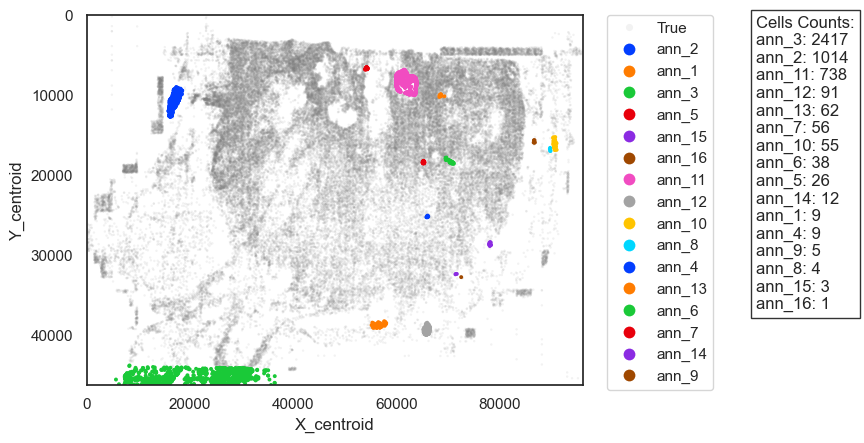

2024-09-16 16:37:10.912 | INFO     | utils:filter_by_annotation:205 -  ---- filter_by_annotation is done, took 34s  ----


In [267]:
adata = utils.filter_by_annotation(adata, path_to_geojson=path_to_geojson)

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning:

divide by zero encountered in log10



Threshold for DAPI intensity: 66.07


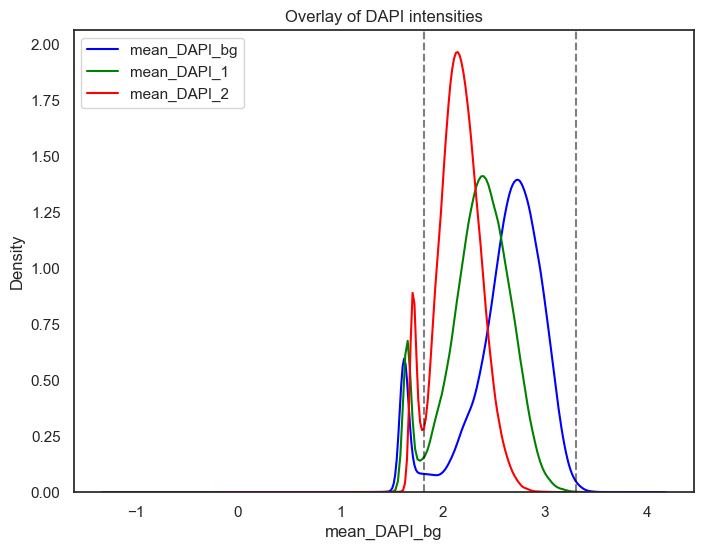

In [268]:
# Plot the density plot for each column
plt.figure(figsize=(8,6))
tmp_df = np.log10(pd.DataFrame(adata.X, columns=adata.var_names))
sns.kdeplot(tmp_df['mean_DAPI_bg'], label='mean_DAPI_bg', color='blue')
sns.kdeplot(tmp_df['mean_DAPI_1'], label='mean_DAPI_1', color='green')
sns.kdeplot(tmp_df['mean_DAPI_2'], label='mean_DAPI_2', color='red')

threshold = 1.82
plt.axvline(threshold, color='black', linestyle='--', alpha=0.5)
print(f"Threshold for DAPI intensity: {10**threshold:.2f}")

plt.axvline(3.3, color='black', linestyle='--', alpha=0.5)

plt.title('Overlay of DAPI intensities')
plt.legend()
plt.show()

2024-09-16 16:37:12.645 | INFO     | utils:filter_by_abs_value:212 -  ---- filter_by_abs_value : version number 1.0.0 ----
2024-09-16 16:37:12.662 | INFO     | utils:filter_by_abs_value:233 - Number of cells with mean_DAPI_bg below 2000: 385747


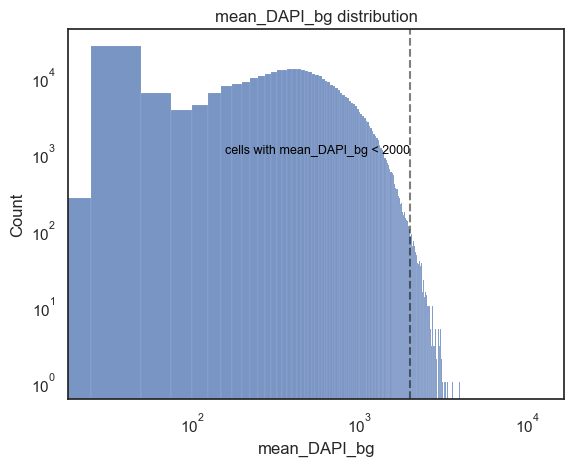

2024-09-16 16:37:13.177 | INFO     | utils:filter_by_abs_value:250 -  ---- filter_by_abs_value is done, took 0s  ----
2024-09-16 16:37:13.177 | INFO     | utils:filter_by_abs_value:212 -  ---- filter_by_abs_value : version number 1.0.0 ----
2024-09-16 16:37:13.192 | INFO     | utils:filter_by_abs_value:228 - Number of cells with mean_DAPI_bg above 66: 356923


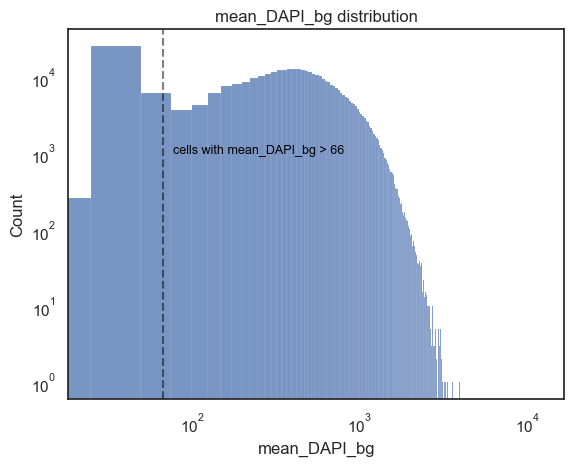

2024-09-16 16:37:13.687 | INFO     | utils:filter_by_abs_value:250 -  ---- filter_by_abs_value is done, took 0s  ----


In [269]:
adata = utils.filter_by_abs_value(adata=adata, marker="mean_DAPI_bg", value=2000, direction="below")
adata = utils.filter_by_abs_value(adata=adata, marker="mean_DAPI_bg", value=66, direction="above")

In [270]:
adata.obs['Area_filter_nottoobig'] = adata.obs['Area'] < 5000
adata.obs['Area_filter_nottoolow'] = adata.obs['Area'] > 400
adata.obs['Area_filter'] = adata.obs['Area_filter_nottoobig'] & adata.obs['Area_filter_nottoolow']

#print stats
print("Number of cells before filtering: ", adata.shape[0])
print("Number of cells filtered out by Area: ", adata.shape[0] - adata.obs['Area_filter'].sum())
print("Percentage of cells filtered out by Area: ", round((adata.shape[0] - adata.obs['Area_filter'].sum())/adata.shape[0]*100, 3), "%")

Number of cells before filtering:  386737
Number of cells filtered out by Area:  14930
Percentage of cells filtered out by Area:  3.861 %


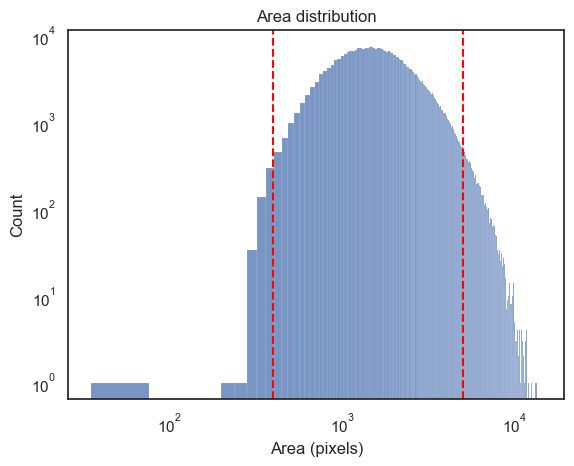

In [271]:
sns.histplot(adata.obs['Area'], bins=350)
plt.yscale('log')
plt.xscale('log')
plt.title('Area distribution')
plt.xlabel('Area (pixels)')
plt.axvline(400, color='red', linestyle='--')
plt.axvline(5000, color='red', linestyle='--')
plt.show()

2024-09-16 16:37:14.189 | INFO     | utils:filter_by_ratio:111 -  ---- filter_by_ratio : version number 1.1.0 ----
2024-09-16 16:37:14.206 | INFO     | utils:filter_by_ratio:129 - Number of cells with DAPI ratio < 0.16: 2937
2024-09-16 16:37:14.219 | INFO     | utils:filter_by_ratio:130 - Number of cells with DAPI ratio > 1.08: 26150
2024-09-16 16:37:14.233 | INFO     | utils:filter_by_ratio:131 - Number of cells with DAPI ratio between 0.16 and 1.08: 357395
2024-09-16 16:37:14.247 | INFO     | utils:filter_by_ratio:132 - Percentage of cells filtered out: 7.59%


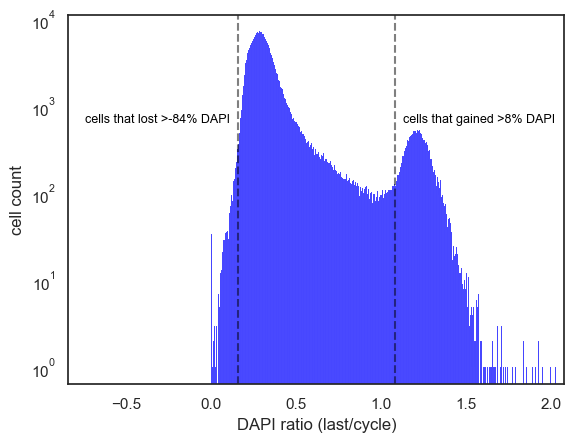

2024-09-16 16:37:15.031 | INFO     | utils:filter_by_ratio:152 -  ---- filter_by_ratio is done, took 0s  ----


In [272]:
adata = utils.filter_by_ratio(
    adata=adata, 
    end_cycle="mean_DAPI_2", 
    start_cycle="mean_DAPI_bg", 
    label="DAPI",
    min_ratio=0.16,
    max_ratio=1.08,
    )

In [273]:
adata = adata[adata.obs['filter_by_ann'].astype(bool) & adata.obs['mean_DAPI_bg_abs_below_value'] & adata.obs['mean_DAPI_bg_abs_above_value'] & adata.obs['Area_filter'] & adata.obs['DAPI_ratio_pass']]

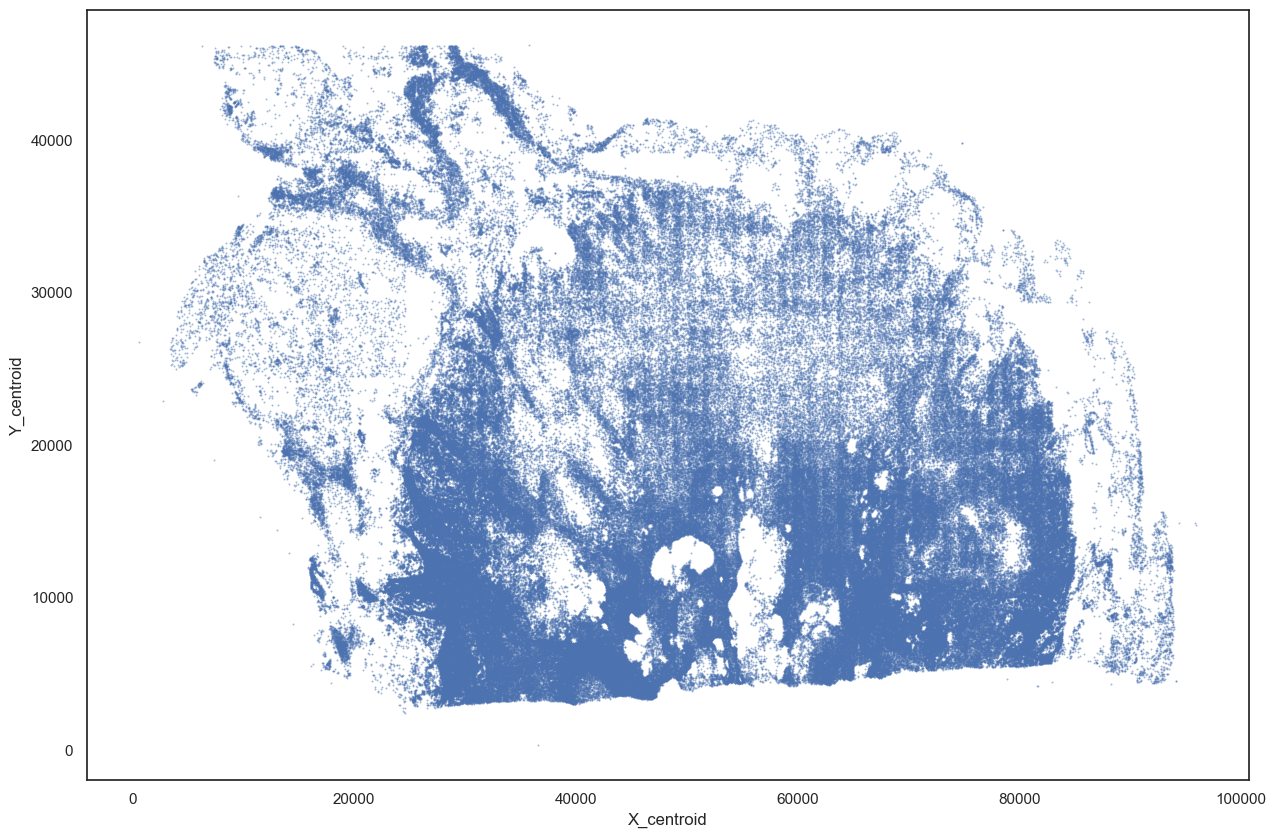

In [274]:
sns.scatterplot(data=adata.obs, x='X_centroid', y='Y_centroid', linewidth=0, s=2, alpha=0.5)
fig = plt.gcf()
fig.set_size_inches(15, 10)

In [275]:
gates = utils.read_gates(path_to_gates)
gates = gates[gates['sample_id']==990]
adata.obs['imageid'] = "990"
gates_990 = utils.process_gates_for_sm(gates, sample_id="990")

2024-09-16 16:37:15.566 | INFO     | utils:read_gates:48 -  ---- read_gates : version number 1.0.0 ----
2024-09-16 16:37:15.568 | INFO     | utils:read_gates:53 -    Filtering out all rows with value 0.0 (assuming not gated)
2024-09-16 16:37:15.569 | INFO     | utils:read_gates:56 -   Found 78 valid gates
2024-09-16 16:37:15.569 | INFO     | utils:read_gates:58 -  ---- read_gates is done, took 0s  ----
/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_82912/1022090423.py:3: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



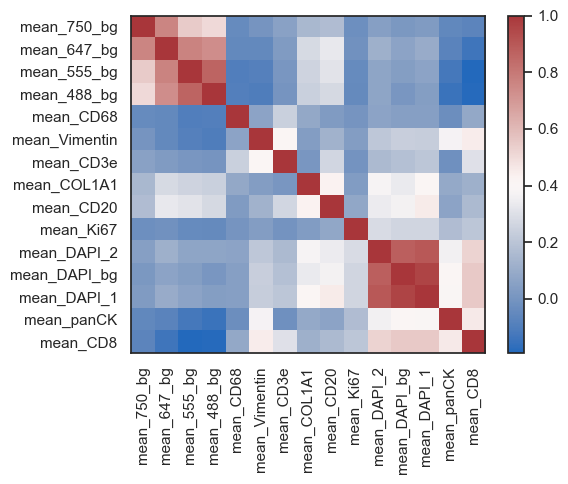

In [282]:
adata = adata[:, adata.var_names.str.contains("mean")]
sm.pl.markerCorrelation(adata, figsize=(6,5), layer=None)

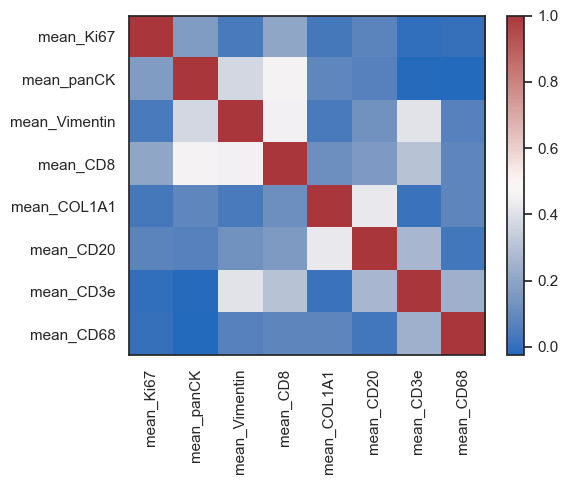

In [283]:
#remove not gated channels
adata = adata[:, adata.var_names.isin(gates_990['marker'])]
sm.pl.markerCorrelation(adata, figsize=(6,5), layer=None)

In [285]:
adata.raw = adata
adata = sm.pp.log1p(adata)

In [286]:
adata = sm.pp.rescale(adata, gate=gates_990, log=True, verbose=True)

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/scimap/preprocessing/rescale.py:105: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Scaling Image 990
Scaling mean_Vimentin
Scaling mean_CD3e
Scaling mean_panCK
Scaling mean_CD8
Scaling mean_COL1A1
Scaling mean_CD20
Scaling mean_CD68
Scaling mean_Ki67


In [287]:
path_to_phenotype_matrix = "../data/phenotyping/20240905_PhenotypeMatrix_v3.csv"
phenotype_matrix = pd.read_csv(path_to_phenotype_matrix)

In [288]:
adata = sm.tl.phenotype_cells (adata, phenotype=phenotype_matrix, label="phenotype") 

Phenotyping Cancer_cells
Phenotyping T_cells
Phenotyping Vimentin_cells
Phenotyping COL1A1_cells
Phenotyping B_cells
Phenotyping Macrophages
-- Subsetting T_cells
Phenotyping CD4_Tcells
Phenotyping CD8_Tcells
Consolidating the phenotypes across all groups


/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:290: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:290: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [289]:
adata.obs.phenotype.value_counts()

phenotype
COL1A1_cells      302049
Cancer_cells       23580
Unknown             6542
CD4_Tcells          3476
Vimentin_cells      2001
Macrophages          692
CD8_Tcells            81
B_cells               57
Name: count, dtype: int64

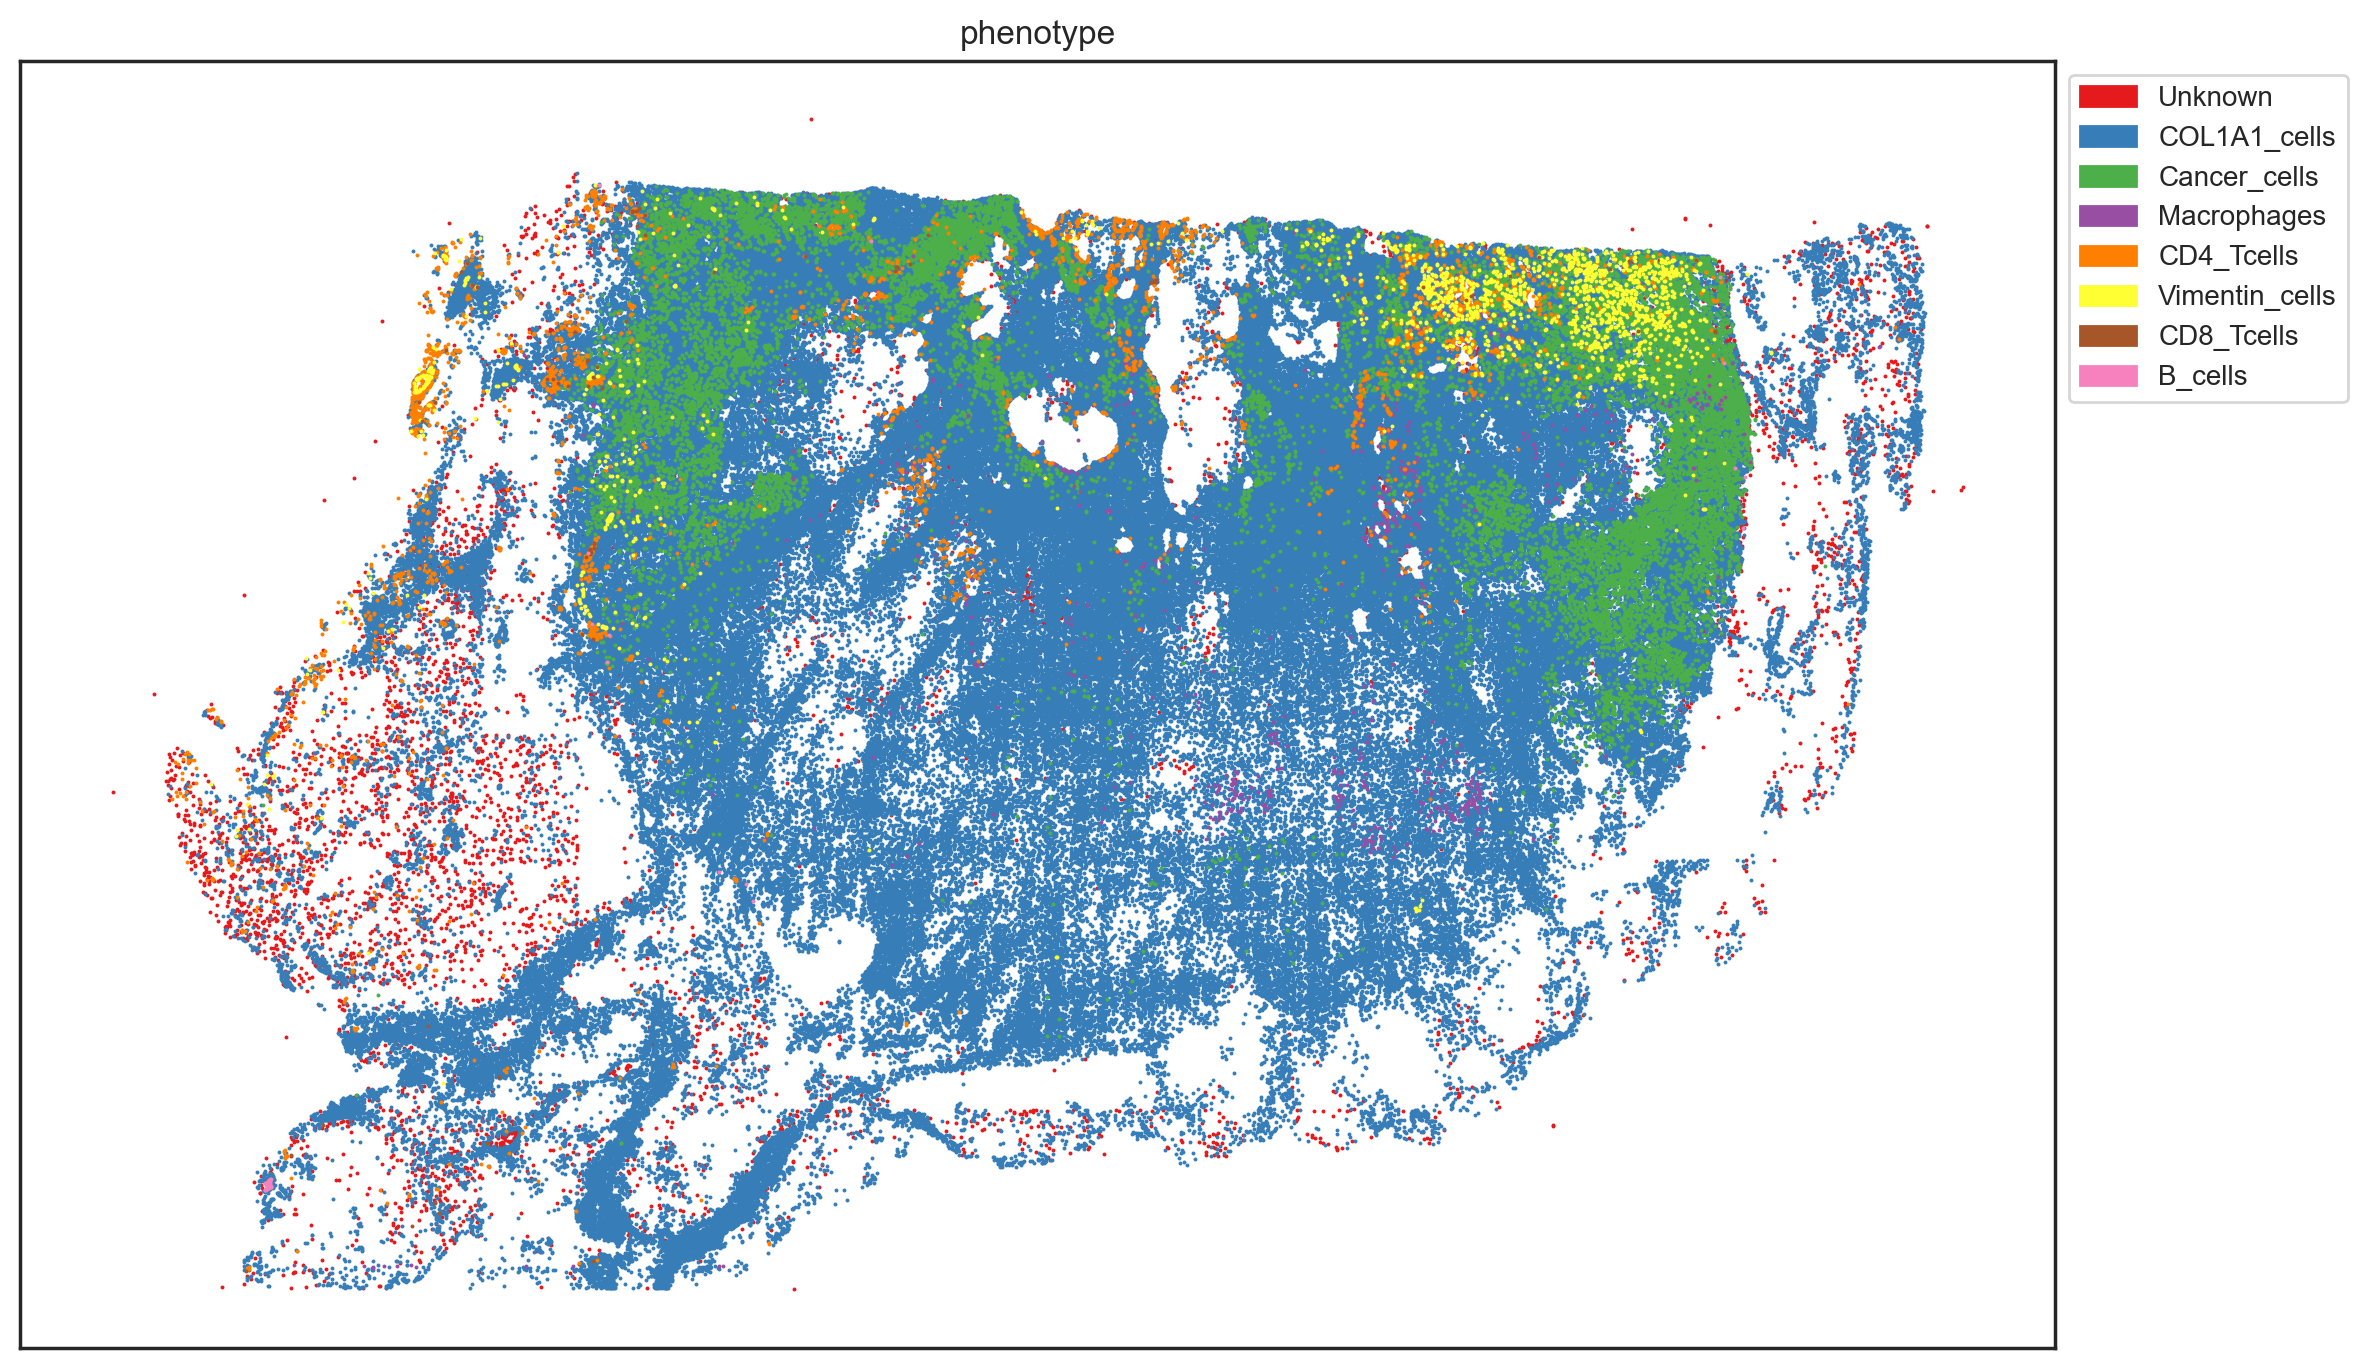

In [293]:
sm.pl.spatial_scatterPlot (adata, colorBy = ['phenotype'],figsize=(12,7), s=2, fontsize=10, catCmap='Set1')